In [ ]:
!pip install catboost==1.2.8 pytorch_tabnet==4.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


In [4]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/final_dataset.csv')

df.head()


,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,127.0.0.1,127.0.0.1,TCP,45,57070 > 57069 [ACK] Seq=1 Ack=1 Win=254 Len=1
1,2,0.000031,127.0.0.1,127.0.0.1,TCP,56,57069 > 57070 [ACK] Seq=1 Ack=2 Win=245 Len=...
2,3,1.014872,127.0.0.1,127.0.0.1,TCP,45,[TCP Keep-Alive] 57070 > 57069 [ACK] Seq=1 A...
3,4,1.014896,127.0.0.1,127.0.0.1,TCP,56,[TCP Keep-Alive ACK] 57069 > 57070 [ACK] Seq...
4,5,2.015128,127.0.0.1,127.0.0.1,TCP,45,[TCP Keep-Alive] 57070 > 57069 [ACK] Seq=1 A...


In [5]:
# Drop irrelevant columns
df.drop(['No.', 'Info'], axis=1, inplace=True)

# Convert Protocol to numerical values (TCP=0, UDP=1, ICMP=2)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Protocol'] = encoder.fit_transform(df['Protocol'])

# Normalize Packet Length
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Length'] = scaler.fit_transform(df[['Length']])

# Show Preprocessed Data
df.head()


,Time,Source,Destination,Protocol,Length
0,0.000000,127.0.0.1,127.0.0.1,4,-0.404769
1,0.000031,127.0.0.1,127.0.0.1,4,-0.173470
2,1.014872,127.0.0.1,127.0.0.1,4,-0.404769
3,1.014896,127.0.0.1,127.0.0.1,4,-0.173470
4,2.015128,127.0.0.1,127.0.0.1,4,-0.404769


In [6]:
# Encode Protocol (TCP=0, UDP=1, ICMP=2)
encoder = LabelEncoder()
df['Protocol'] = encoder.fit_transform(df['Protocol'])

# Normalize Packet Length
scaler = StandardScaler()
df['Length'] = scaler.fit_transform(df[['Length']])

# Add Labels (Normal or Malicious Traffic)
df['Label'] = ['Normal' if x < 0.5 else 'Malicious' for x in df['Length']]


In [7]:
# Separate Features (X) and Labels (y)
X = df.drop('Label', axis=1)
y = df['Label']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **1. CatBoost Training Script**

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost import CatBoostClassifier


# --- CONFIG ---
CSV_PATH = "/content/final_dataset.csv"
LABEL_COLUMN = "Info"
MODEL_PATH = "trained_models/catboost_model.cbm"
# --------------

# Load and preprocess
df = pd.read_csv(CSV_PATH)
for col in ['No.', 'Info']:
    if col in df.columns and col != LABEL_COLUMN:
        df.drop(col, axis=1, inplace=True)
df['Source'] = df['Source'].astype(str)
df['Destination'] = df['Destination'].astype(str)
df['Protocol'] = df['Protocol'].astype(str)
le = LabelEncoder()
df['Source'] = le.fit_transform(df['Source'])
df['Destination'] = le.fit_transform(df['Destination'])
df['Protocol'] = le.fit_transform(df['Protocol'])
scaler = StandardScaler()
df['Length'] = scaler.fit_transform(df[['Length']])

X = df[['Source', 'Destination', 'Protocol', 'Length']]
y = LabelEncoder().fit_transform(df[LABEL_COLUMN])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_model.save_model(MODEL_PATH)
print("CatBoost model saved to", MODEL_PATH)

CatBoost model saved to trained_models/catboost_model.cbm


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = cat_model.predict(X_test)

print("CatBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


CatBoost Classifier
Accuracy: 0.9251934651762683
Precision: 0.9187241534619006
Recall: 0.9251934651762683
F1-Score: 0.9204261010795834


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **2. LightGBM Training Script**

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMClassifier
import joblib

# --- CONFIG ---
CSV_PATH = "/content/final_dataset.csv"
LABEL_COLUMN = "Info"
MODEL_PATH = "trained_models/lightgbm_model.txt"
# --------------

df = pd.read_csv(CSV_PATH)
for col in ['No.', 'Info']:
    if col in df.columns and col != LABEL_COLUMN:
        df.drop(col, axis=1, inplace=True)
df['Source'] = df['Source'].astype(str)
df['Destination'] = df['Destination'].astype(str)
df['Protocol'] = df['Protocol'].astype(str)
le = LabelEncoder()
df['Source'] = le.fit_transform(df['Source'])
df['Destination'] = le.fit_transform(df['Destination'])
df['Protocol'] = le.fit_transform(df['Protocol'])
scaler = StandardScaler()
df['Length'] = scaler.fit_transform(df[['Length']])

X = df[['Source', 'Destination', 'Protocol', 'Length']]
y = LabelEncoder().fit_transform(df[LABEL_COLUMN])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
joblib.dump(lgb_model.booster_, MODEL_PATH)
print("LightGBM model saved to", MODEL_PATH)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [17]:
import joblib
MODEL_PATH = "trained_models/lightgbm_model.pkl"


# Save the entire sklearn model
joblib.dump(lgb_model, MODEL_PATH)
print("LightGBM sklearn model saved to", MODEL_PATH)

LightGBM sklearn model saved to trained_models/lightgbm_model.pkl


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lgb_model.predict(X_test)

print("LightGBM Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


LightGBM Classifier
Accuracy: 0.8684436801375752
Precision: 0.8583494141561432
Recall: 0.8684436801375752
F1-Score: 0.8600092116089086


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **3. TabNet Training Script**

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier

# --- CONFIG ---
CSV_PATH = "/content/final_dataset.csv"
LABEL_COLUMN = "Info"
MODEL_PATH = "trained_models/tabnet_model.zip"
# --------------

df = pd.read_csv(CSV_PATH)
for col in ['No.', 'Info']:
    if col in df.columns and col != LABEL_COLUMN:
        df.drop(col, axis=1, inplace=True)
df['Source'] = df['Source'].astype(str)
df['Destination'] = df['Destination'].astype(str)
df['Protocol'] = df['Protocol'].astype(str)
le = LabelEncoder()
df['Source'] = le.fit_transform(df['Source'])
df['Destination'] = le.fit_transform(df['Destination'])
df['Protocol'] = le.fit_transform(df['Protocol'])
scaler = StandardScaler()
df['Length'] = scaler.fit_transform(df[['Length']])

X = df[['Source', 'Destination', 'Protocol', 'Length']]
y = LabelEncoder().fit_transform(df[LABEL_COLUMN])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tabnet_model = TabNetClassifier(verbose=0)
tabnet_model.fit(X_train.values, y_train, max_epochs=10, batch_size=128)
tabnet_model.save_model(MODEL_PATH)
print("TabNet model saved to", MODEL_PATH)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Successfully saved model at trained_models/tabnet_model.zip.zip
TabNet model saved to trained_models/tabnet_model.zip


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = tabnet_model.predict(X_test.values)

print("TabNet Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


TabNet Classifier
Accuracy: 0.4772141014617369
Precision: 0.24573945234179645
Recall: 0.4772141014617369
F1-Score: 0.32344862864503765


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


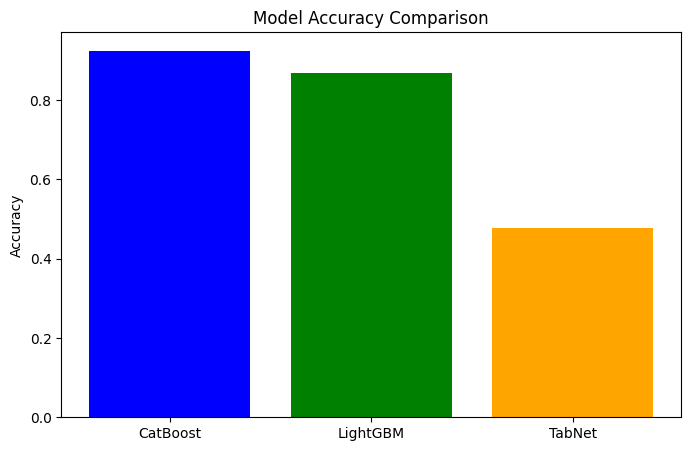

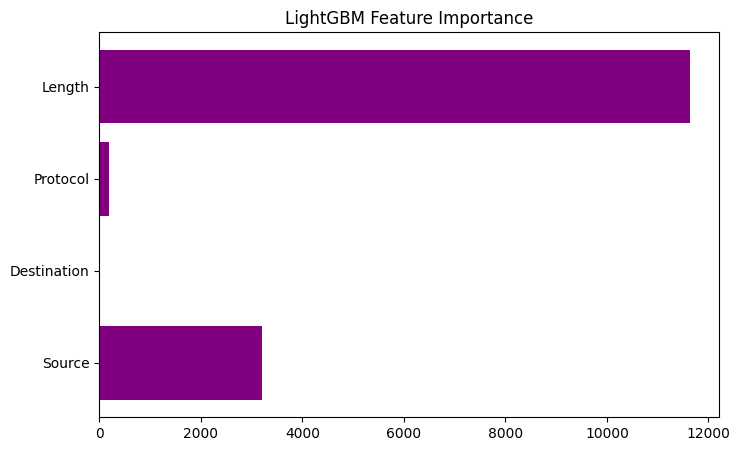

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model performance comparison
models = ['CatBoost', 'LightGBM', 'TabNet']
accuracies = [accuracy_score(y_test, cat_model.predict(X_test)),
              accuracy_score(y_test, lgb_model.predict(X_test)),
              accuracy_score(y_test, tabnet_model.predict(X_test.values))]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()



# Feature Importance for LightGBM
plt.figure(figsize=(8, 5))
plt.barh(X.columns, lgb_model.feature_importances_, color='purple')
plt.title('LightGBM Feature Importance')
plt.show()
